In [1]:
import torch
from GEM_module_sparse import Generalized_EM
from utils_sparse import *
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import scipy.sparse as sp
import sksparse.cholmod as cholmod

edge_attr: {(0, 5): 0.14411993324756622, (0, 1): 0.11266419291496277, (0, 6): 0.4747416377067566, (0, 10): 0.41393494606018066, (0, 2): 0.4039943218231201, (0, 11): 0.1775568574666977, (0, 7): 0.3291775584220886, (0, 12): 0.40668290853500366, (5, 1): 0.4112762212753296, (5, 2): 0.22385042905807495, (5, 10): 0.46602362394332886, (5, 6): 0.42357194423675537, (5, 11): 0.5929414629936218, (5, 15): 0.5161319971084595, (5, 7): 0.4940219223499298, (5, 16): 0.47008898854255676, (5, 12): 0.30274561047554016, (5, 17): 0.4124198257923126, (1, 6): 0.584747314453125, (1, 2): 0.12958058714866638, (1, 7): 0.19856177270412445, (1, 11): 0.9374245405197144, (1, 3): 0.5480265617370605, (1, 10): 0.614849865436554, (1, 12): 0.2497146874666214, (1, 8): 0.04832439497113228, (1, 13): 0.3899381458759308, (6, 2): 0.5659615993499756, (6, 3): 0.8476806879043579, (6, 11): 0.6738850474357605, (6, 7): 0.2820703685283661, (6, 10): 0.991593599319458, (6, 12): 0.7619694471359253, (6, 16): 0.8480795621871948, (6, 8): 0.

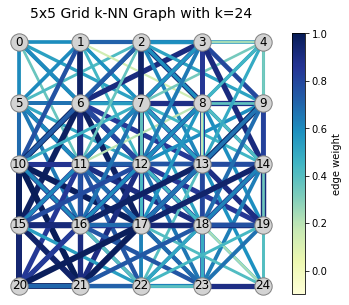

In [2]:
n_row = 5
kernel = 5
k = kernel ** 2 - 1
feature_dim = 3
num_nodes = n_row * n_row
# signal 
features = torch.randn(num_nodes, feature_dim) * 0.4
    # compute weight matrix
    # nearest_neighbors = generate_grid_neigbhors(n_row) #  generate_kNN_from_grid(n_row, kernel, k)
    # edge_weights = features[nearest_neighbors.view(-1)].reshape(num_nodes, 4, feature_dim) - features.unsqueeze(1)  # (N, 4, feature_dim)
    # edge_weights = torch.exp(- (edge_weights ** 2).sum(-1))  # (N, 4)


nearest_neighbors = generate_kNN_from_grid(n_row, kernel, k)
neighbor_mask = nearest_neighbors != -1
edge_weights = features[nearest_neighbors.view(-1)].reshape(num_nodes, k, feature_dim) - features.unsqueeze(1)  # (N, k, feature_dim)
edge_weights = torch.exp(- (edge_weights ** 2).sum(-1))  # (N, k)
edge_weights = edge_weights * neighbor_mask.float()

draw_graph(nearest_neighbors, edge_weights, n_row, title=f"{n_row}x{n_row} Grid k-NN Graph with k={k}")



tensor([[ 5,  1, -1, -1],
        [ 0,  6,  2, -1],
        [ 1,  7,  3, -1],
        [ 2,  8,  4, -1],
        [ 3,  9, -1, -1],
        [ 0, 10,  6, -1],
        [ 5,  1, 11,  7],
        [ 6,  2, 12,  8],
        [ 7,  3, 13,  9],
        [ 8,  4, 14, -1],
        [ 5, 15, 11, -1],
        [10,  6, 16, 12],
        [11,  7, 17, 13],
        [12,  8, 18, 14],
        [13,  9, 19, -1],
        [10, 20, 16, -1],
        [15, 11, 21, 17],
        [16, 12, 22, 18],
        [17, 13, 23, 19],
        [18, 14, 24, -1],
        [15, 21, -1, -1],
        [20, 16, 22, -1],
        [21, 17, 23, -1],
        [22, 18, 24, -1],
        [23, 19, -1, -1]]) tensor([[0.6000, 0.6000, 0.0000, 0.0000],
        [0.6000, 0.6000, 0.6000, 0.0000],
        [0.6000, 0.6000, 0.6000, 0.0000],
        [0.6000, 0.6000, 0.6000, 0.0000],
        [0.6000, 0.6000, 0.0000, 0.0000],
        [0.6000, 0.6000, 0.6000, 0.0000],
        [0.6000, 0.6000, 0.6000, 0.6000],
        [0.6000, 0.6000, 0.6000, 0.6000],
        [0.60

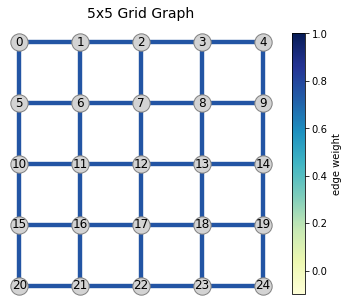

y.shape torch.Size([128, 25])
5 E-step CG residual norms: [tensor([0.1463, 0.1290, 0.1120, 0.1887, 0.0916, 0.1344, 0.0990, 0.1376, 0.1605,
        0.0725, 0.1169, 0.1425, 0.1646, 0.1322, 0.1707, 0.1828, 0.1586, 0.2156,
        0.1562, 0.1305, 0.1309, 0.0975, 0.1435, 0.0891, 0.1859, 0.1421, 0.1272,
        0.2155, 0.0846, 0.1629, 0.1588, 0.1532, 0.1437, 0.1178, 0.1564, 0.1519,
        0.1405, 0.1590, 0.1252, 0.1369, 0.1613, 0.0795, 0.1423, 0.1493, 0.1076,
        0.1620, 0.0986, 0.1297, 0.1291, 0.1280, 0.1495, 0.1138, 0.1547, 0.1593,
        0.1350, 0.1682, 0.1871, 0.1430, 0.1129, 0.1216, 0.1359, 0.1491, 0.1078,
        0.1811, 0.1197, 0.1125, 0.1355, 0.1380, 0.1613, 0.1937, 0.1200, 0.0807,
        0.1650, 0.1124, 0.1386, 0.1742, 0.1694, 0.1056, 0.0911, 0.1285, 0.1566,
        0.1319, 0.1483, 0.1518, 0.1847, 0.1101, 0.1316, 0.1674, 0.1090, 0.2634,
        0.1332, 0.1074, 0.2108, 0.1478, 0.1386, 0.1206, 0.1850, 0.0949, 0.1336,
        0.0987, 0.1811, 0.1431, 0.1457, 0.1583, 0.1159, 0.189

In [3]:
gem = Generalized_EM(num_nodes=num_nodes, num_neighbors=k, neighbor_list=nearest_neighbors, mu=0.01, gamma=0.1, step_size=0.1, emb_dim=6, feature_dim=feature_dim, c=8, theta=0.5, method='CG', CG_iters=5, PGD_iters=100, PGD_step_size=0.01, use_block_coordinate=False, scale=True)

gem.neighbor_mask = neighbor_mask  # set neighbor mask

y = generate_y_from_grid(n_row, sigma=0.1, n=128)
print('y.shape', y.shape)  # (128, num_nodes)

# solve x
x = gem.E_step(y, edge_weights)  # (B, N)
print('x.shape', x.shape)
print('difference norm:', torch.norm(gem.LHS_E_step(x, edge_weights) - y))


In [4]:
# VALIDATE r-TILDE
r_tilde = gem._r_tilde(edge_weights, CG_method='batch_PCG')  # (B, N)
print((r_tilde * edge_weights).sum())
r_tilde = gem._r_tilde(edge_weights, CG_method='batch_CG')  # (B, N)
print((r_tilde * edge_weights).sum())

6 r_tilde CG residual norms: [tensor([1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142,
        1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142,
        1.4142, 1.4142, 1.4142, 1.4142, 1.4142, 1.4142]), tensor([0.2906, 0.2569, 0.3400, 0.3819, 0.2649, 0.2881, 0.3415, 0.3189, 0.4219,
        0.2934, 0.3331, 0.3043, 0.3536, 0.4259, 0.3211, 0.3321, 0.3394, 0.3905,
        0.4494, 0.4187, 0.4051, 0.4071, 0.4526, 0.5518]), tensor([0.0483, 0.0782, 0.0928, 0.1170, 0.0611, 0.0715, 0.0796, 0.0987, 0.1216,
        0.0898, 0.0881, 0.0867, 0.1083, 0.1286, 0.0971, 0.0986, 0.1014, 0.1062,
        0.1186, 0.1078, 0.1102, 0.1072, 0.1178, 0.1410]), tensor([0.0284, 0.0311, 0.0358, 0.0343, 0.0318, 0.0521, 0.0341, 0.0274, 0.0393,
        0.0453, 0.0479, 0.0432, 0.0400, 0.0401, 0.0457, 0.0494, 0.0471, 0.0402,
        0.0376, 0.0461, 0.0509, 0.0331, 0.0314, 0.0291]), tensor([0.0272, 0.0243, 0.0287, 0.0180, 0.0286, 0.0441, 0.0322, 0.0210, 0.0266,
        0.0485, 0.

In [5]:
glr = gem.GLR(x, edge_weights, method='Lx')
glr_1 = gem.GLR(x, edge_weights, method='edge_diff')
print(glr, glr_1)
print('GLR difference norm:', torch.norm(glr - glr_1))  # should be close to 0

tensor(114.7911) tensor(114.7911)
GLR difference norm: tensor(7.6294e-06)
